# Метрики качества (ранжирования)

https://habr.com/ru/company/econtenta/blog/303458/

### Практика по groupby.

In [1]:
import pandas as pd

dtypes = {
    "first_name": "category",
    "last_name": "category",
    "gender_bio": "category",
    "religion_bio": "category",
    "suffix_name": "category",
}
df = pd.read_csv(
    "legislators_historical.csv",
    dtype=dtypes,
    usecols = ['last_name', 'first_name', 'gender_bio', 'birthday_bio', 'religion_bio', \
               'suffix_name']
)

df.head()

,birthday_bio,first_name,gender_bio,last_name,religion_bio,suffix_name
0,1745-04-02,Richard,M,Bassett,NaN,NaN
1,1742-03-21,Theodorick,M,Bland,NaN,NaN
2,1743-06-16,Aedanus,M,Burke,NaN,NaN
3,1730-07-22,Daniel,M,Carroll,NaN,NaN
4,1739-03-16,George,M,Clymer,NaN,NaN


In [2]:
df.dtypes

birthday_bio      object
first_name      category
gender_bio      category
last_name       category
religion_bio    category
suffix_name     category
dtype: object

Для каждой религии (religion_bio) вычислите количество её приверженцев.

#### df.groupby(столбцы, по которым группируем)[[список отображаемых столбцов]].функция

#### Функции: count, size, sum, mean, max, min, first, last

In [3]:
n_by_religion = df.groupby('religion_bio')['last_name'].count()
n_by_religion.head(10)

religion_bio
African Methodist Episcopal                      1
Assembly of God                                  3
Baptist                                         44
Catholic                                        32
Christian                                       10
Christian Reformed                               1
Christian Scientist                              3
Congregationalist                                4
Episcopalian                                    31
First Christian Church (Disciples of Christ)     2
Name: last_name, dtype: int64

Вычислите количество приверженцев каждой религии каждого пола.

In [4]:
df.groupby(['religion_bio','gender_bio'])['last_name'].count()

religion_bio                                  gender_bio
African Methodist Episcopal                   F              1
Assembly of God                               F              2
                                              M              1
Baptist                                       F              4
                                              M             40
Catholic                                      F              6
                                              M             26
Christian                                     M             10
Christian Reformed                            M              1
Christian Scientist                           M              3
Congregationalist                             M              4
Episcopalian                                  F              5
                                              M             26
First Christian Church (Disciples of Christ)  M              2
Greek Orthodox                                F              

После применения groupby получаем объект типа pandas Series.

In [5]:
type(n_by_religion)

pandas.core.series.Series

Преобразуйте объект n_by_religion в dataframe.

In [6]:
n_by_religion_df = n_by_religion.reset_index()
n_by_religion_df.head(3)

,religion_bio,last_name
0,African Methodist Episcopal,1
1,Assembly of God,3
2,Baptist,44


Выведите на экран для каждой религии last_name и gender_bio первого человека из df, который исповедует эту религию. На выходе получите dataframe.

In [10]:
df_gen_name = df.groupby('religion_bio')[['last_name','gender_bio']] \
                .first() \
                .reset_index()
df_gen_name.head(3)

,religion_bio,last_name,gender_bio
0,African Methodist Episcopal,Majette,F
1,Assembly of God,Davis,F
2,Baptist,Hutchinson,M


К полученной таблице примените groupby, чтобы выяснить, сколько раз каждый пол встречается в этой таблице.

In [13]:
df_gen_name.groupby('gender_bio')['last_name'].count()

gender_bio
F     6
M    25
Name: last_name, dtype: int64

Заполните пропуски в столбце birthday_bio датой '1950-00-00'. 

Создайте столбец age, в котором вычислите возраст (в годах) каждого человека.

С помощью groupby вычислите средний возраст для приверженцев каждой религии.

In [16]:
#your code here
df['birthday_bio'].fillna('1950-00-00', inplace=True)
df['age'] = df['birthday_bio'].apply(lambda x: 2020-int(x.split('-')[0]))
df.groupby('religion_bio')['age'].mean()

religion_bio
African Methodist Episcopal                     65.000000
Assembly of God                                 70.000000
Baptist                                         72.590909
Catholic                                        70.750000
Christian                                       70.500000
Christian Reformed                              86.000000
Christian Scientist                             71.333333
Congregationalist                               85.250000
Episcopalian                                    73.870968
First Christian Church (Disciples of Christ)    82.500000
Greek Orthodox                                  83.333333
Jewish                                          74.541667
Latter Day Saints                               74.181818
Lutheran                                        75.555556
Methodist                                       76.150000
Moravian                                        75.000000
Non-Denominational                              73.000000
P

In [14]:
'1950-00-00'.split('-')

['1950', '00', '00']

***np.in1d(array1, array2) - для каждого элемента array1 проверяет, присутствует ли он в array2.***

In [17]:
import numpy as np

test = np.array([0, 1, 2, 5, 0])
states = [0, 2]
mask = np.in1d(test, states)
mask

array([ True, False,  True, False,  True])

### Рекомендательные системы. Часть 1.

В этом задании будем практиковаться в реализации рекомендательных систем.

Воспользуемся небольшим датасетом с Kaggle: [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

In [18]:
import numpy as np
import scipy
import pandas as pd
import math

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

## Часть 0. Загрузка данных

Загрузим [Deskdrop dataset](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop), включающийся в себе логи за 1 год платформы, где пользователи читают статьи.

Данные включают в себя 2 файла:  
- **shared_articles.csv**
- **users_interactions.csv**

Как можно догадаться, в одном описания самих статей (нам понадобятся в контентных моделях), а в другом логи пользователей.

#### shared_articles.csv

Так как в файле перечислены даже удалённые статьи, то мы их сразу удалим (на самом деле они могли бы быть нам полезны для подсчёта различных величин, хоть мы и не можем их рекомендовать).

In [19]:
articles_df = pd.read_csv('shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


#### users_interactions.csv

В колонке eventType описаны действия, которые могли совершать пользователи над статьёй:  
- VIEW
- LIKE
- COMMENT CREATED
- FOLLOW
- BOOKMARK

In [20]:
interactions_df = pd.read_csv('users_interactions.csv')
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


In [21]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

### Предобработка данных

В логах встречаются различные действия пользователей. Однако мы хотим работать лишь с одной величиной, характеризующей всё взаимодействие пользователя со статьёй. Предлагается задать действиям следующие веса:

In [23]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

Посчитайте числовую величину "оценки" пользователем статьи с указанными выше весами.

In [24]:
interactions_df['eventStrength'] = interactions_df['eventType'].apply(
                                        lambda x: event_type_strength[x])

# interactions_df['eventStrength'] = interactions_df['eventType'].map(
#                                                     event_type_strength)
interactions_df['eventStrength']

0        1.0
1        1.0
2        1.0
3        3.0
4        1.0
5        1.0
6        1.0
7        1.0
8        1.0
9        1.0
10       1.0
11       1.0
12       1.0
13       1.0
14       1.0
15       1.0
16       1.0
17       1.0
18       1.0
19       1.0
20       1.0
21       1.0
22       1.0
23       1.0
24       1.0
25       2.5
26       1.0
27       2.5
28       1.0
29       1.0
        ... 
72282    1.0
72283    2.0
72284    1.0
72285    1.0
72286    1.0
72287    2.0
72288    1.0
72289    1.0
72290    1.0
72291    1.0
72292    1.0
72293    1.0
72294    1.0
72295    2.5
72296    1.0
72297    1.0
72298    1.0
72299    1.0
72300    1.0
72301    1.0
72302    1.0
72303    1.0
72304    2.5
72305    1.0
72306    1.0
72307    2.0
72308    1.0
72309    1.0
72310    1.0
72311    1.0
Name: eventStrength, Length: 72312, dtype: float64

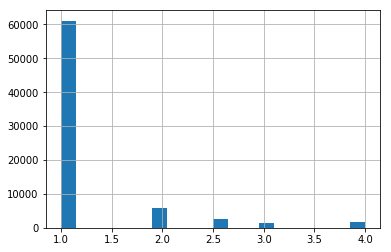

In [25]:
interactions_df.eventStrength.hist(bins=20)

Ремендательные системы подвержены проблеме холодного старта. В рамках данного задания предлагается работать только с теми пользователями, которые взаимодействовали хотя бы с 5 материалами.

Оставьте только таких пользователей. Их должно остаться 1140.

1. Создайте с помощью groupby объект users_interactions_count_df, в котором для каждого пользователя оставьте только первое взаимодействие с каждой статьей. Затем сгруппируйте полученную таблицу по пользователям для подсчета количества статей, с которыми взаимодействовал пользователь.

2. Создайте таблицу users_with_enough_interactions_df, в которой оставьте только пользователей
(users_interactions_count_df), которые взаимодействовали хотя бы с пятью статьями.

In [31]:
interactions_df

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1.0
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,3.0
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN,1.0
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR,1.0
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN,1.0
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,1.0
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN,1.0


In [32]:
users_interactions_count_df = interactions_df \
                                       .groupby(['personId','contentId']) \
                                       .first() \
                                       .reset_index() \
                                       .groupby('personId') \
                                       .size()

print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5] \
                                    .reset_index()[['personId']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


Оставьте только те взаимодействия из таблицы interactions_df, которые касаются только отфильтрованных пользователей.

In [33]:
interactions_from_selected_users_df = interactions_df.loc[
    np.in1d(interactions_df.personId, users_with_enough_interactions_df)
]

In [34]:
print('# interactions before:', interactions_df.shape)
print('# interactions after:', interactions_from_selected_users_df.shape)

# interactions before: (72312, 9)
# interactions after: (69868, 9)


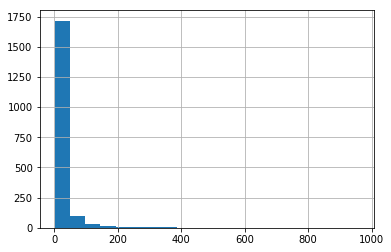

In [35]:
users_interactions_count_df.hist(bins=20)

В данной постановке каждый пользователей мог взаимодействовать с каждой статьёй более 1 раза (как минимум совершая различные действия). Предлагается "схлопнуть" все действия в одно взаимодействие с весом, равным сумме весов. 

Однако полученное число будет в том числе тем больше, чем больше действий произвёл человек. Чтобы уменьшить разброс предлагается взять логарифм от полученного числа (можно придумыват другие веса действиям и по-другому обрабатывать значения).

Также сохраним последнее значение времени взаимодействия для разделениея выборки на обучение и контроль.

***С помощью groupby создайте объект interactions_full_df, в котором для каждой пары personId-contentId посчитайте сумму взаимодействий (eventStrength), затем примените к нему сглаживание (smooth_user_preference) и сохраните как dataframe с колонками-индексами personId и contentId.***

In [36]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                                .groupby(['personId','contentId']) \
                                .eventStrength.sum() \
                                .apply(smooth_user_preference) \
                                .reset_index() \
                                .set_index(['personId','contentId'])

interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(10)

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324
5,-1007001694607905623,8729086959762650511,1.000000,1487240086
6,-1032019229384696495,-1006791494035379303,1.000000,1469129122
7,-1032019229384696495,-1039912738963181810,1.000000,1459376415
8,-1032019229384696495,-1081723567492738167,2.000000,1464054093
9,-1032019229384696495,-1111518890369033396,1.000000,1470109122


Разбейте выборку на обучение и контроль по времени (train - объекты с last_timestamp < split_ts, test - остальные объекты).

In [37]:
split_ts = 1475519530
interactions_train_df = interactions_full_df[interactions_full_df.last_timestamp < split_ts]
interactions_test_df = interactions_full_df[interactions_full_df.last_timestamp >= split_ts]

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 29329
# interactions on Test set: 9777


Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [38]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    list() for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(1)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."


## Часть 1: Baseline (модель по популярности)

Самой простой моделью рекомендаций (при этом достаточно сильной!) является модель, которая рекомендует наиболее популярные статьи. 

Предлагается реализовать её. Давайте считать, что рекомендуем мы по 10 материалов (такое ограничение на размер блока на сайте).

In [39]:
interactions_train_df.head()

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093


Посчитайте популярность каждой статьи, как сумму всех "оценок" взаимодействий с ней. Отсортируйте материалы по убыванию их популярности. Как результат создайте массив popular_content, состоящий из отсортированных по популярности статей.

In [40]:
popular_content = interactions_train_df.groupby('contentId') \
                                       .eventStrength.sum() \
                                       .reset_index() \
                                       .sort_values('eventStrength',ascending=False) \
                                       .contentId \
                                       .values

In [41]:
popular_content

array(['-6783772548752091658', '-133139342397538859',
       '-8208801367848627943', ..., '6240076106289531207',
       '6541551984368289722', '7083316110921342538'], dtype=object)

Теперь необходимо сделать предсказания для каждого пользователя. Не забывайте, что надо рекомендовать то, что пользователь ещё не читал (для этого нужно проверить, что материал не встречался в true_train).

In [42]:
top_k = 10

interactions['prediction_popular'] = (
    interactions.true_train
    .apply(
        lambda x:
        popular_content[~np.in1d(popular_content, x)][:top_k]
    )
)

Настало время оценить качество. Посчитаем precision@10 для каждого пользователя (доля угаданных рекомендаций). Усредните по всем пользователям. Везде далее будем считать эту же метрику.

(для каждого пользователя посчитаем долю правильно предсказанных статей (если в ответе их меньше 10ти, то будем нормировать на реальное количество статей)).

In [43]:
def calc_precision(column):
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

In [44]:
calc_precision('prediction_popular')

0.006454207722621084

In [ ]:
interactions.true_test.apply(len).sum()

## Часть 2. Коллаборативная фильтрация.

Перейдём к более сложному механизму рекомендаций, а именно коллаборативной фильтрации. Суть коллаборативной фильтрации в том, что учитывается схожесть пользователей и товаров между собой, а не факторы, которые их описывают. 

Реализуем memory-based подход.

Для начала для удобства составим матрицу "оценок" пользователей. Нули будут обозначать отсутствие взаимодействия.

In [ ]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='personId',
    columns='contentId').fillna(0)

In [ ]:
ratings.head()

### Memory-based

Посчитайте схожести пользователей с помощью корреляции Пирсона. Для каждой пары учитываем только ненулевые значения.

Для скорости работы лучше переходить от pandas к numpy.

In [ ]:
ratings_m = ratings.as_matrix()

Дозаполните код: 

1) Отнормируйте рейтинги (поделите рейтинг на его норму).

2) Вычислите корреляцию между пользователями.

In [ ]:
similarity_users = np.zeros((len(ratings_m), len(ratings_m)))

for i in tqdm_notebook(range(len(ratings_m)-1)):
    for j in range(i+1, len(ratings_m)):
        
        # nonzero elements of two users
        mask_uv = (ratings_m[i] != 0) & (ratings_m[j] != 0)
        
        # continue if no intersection
        if np.sum(mask_uv) == 0:
            continue
            
        # get nonzero elements
        ratings_v = ratings_m[i, mask_uv]
        ratings_u = ratings_m[j, mask_uv]
        
        # normalization
        # YOUR CODE HERE
        
        # for nonzero std
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue
        
        similarity_users[i,j] = # YOUR CODE HERE
        similarity_users[j,i] = # YOUR CODE HERE

Теперь у нас есть матрицы схожести пользователей. Их можно использовать для рекомендаций.

Для каждого пользователя:

1. Найдём пользователей с похожестью больше $\alpha$ на нашего пользователя.
2. Посчитаем для каждой статьи долю пользователей (среди выделенных на первом шаге), которые взаимодействовали со статьёй.
3. Порекомендуем статьи с наибольшими долями со второго шага (среди тех, которые пользователь ещё не видел).

В нашем примере данных не очень много, поэтому возьмём $\alpha = 0$.

После того, как будут сделаны предсказания (новый столбец в interactions), посчитайте качество по той же метрике.

In [1]:
#1. users_sim - массив, где похожие на данного пользователя пользователи 
#   отмечены как True, а остальные как False.

#2. tmp_recommend - статьи, с которыми взаимодействовали пользователи, похожие на нашего.
#   для подсчета tmp_recommend:
#   1. Оставьте в матрице ratings_m только похожих пользователей (users_sim)
#   2. Просуммируйте значения в строках. Затем отсортируйте номера строк (np.argsort) 
#      по убыванию (популярности).
#   3. Оставьте только колонки tmp_recommend в матрице ratings (наиболее популярные статьи)
#      и сохраните их как np.array под названием tmp_recommend_arr.

#3. recommend - 10 статей с наибольшими долями. Исключите из tmp_recommend_arr статьи, 
#   которые пользователь уже видел.

In [ ]:
prediction_user_based = []
for i in tqdm_notebook(range(len(similarity_users))):
        
    users_sim = #your code here

    if sum(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = #your code here
        tmp_recommend_arr = #your code here
        recommend = #your code here
        prediction_user_based.append(list(recommend))

interactions['prediction_user_based'] = prediction_user_based

In [ ]:
calc_precision('prediction_user_based')